# Galaxy Zoo star-formation rate data analysis activity
## Data preparation

This activity uses the data for Fig. 6 and 7 of [this paper](https://arxiv.org/pdf/1703.02053). It compares two different estimates of the star-formation rate for samples of galaxies with different numbers of spiral arms (see Figure. 11 in this [other paper](https://arxiv.org/pdf/1607.01019)).

Star-formation rates (SFRs) ares estimated directly from far-UV (FUV) and mid-infrared (MIR; 22 micron) photometry. Stellar mass is used to determine the specific star-formation rate (sSFR).

One could:
* Propagate errors for eqns. (4), (5), (6), log(sSFR) and also for log(SFR_FUV/SFR_22).
* Show that the scatter in the distribution is significantly larger than the propagated uncertainties, i.e. there is intrinsic variation in the sSFR of galaxies.
* Use different sized samples to demonstrate that the error on the mean goes as 1/sqrt(N), and that it has a Gaussian distribution, even when the original quantity is non-Gaussian.
* Test for statistical differences in mean log(sSFR) and log(SFR_FUV/SFR_22) for galaxies with different numbers of spiral arms. Maybe you could first use resampled distributions of different sizes, then show that the results are the similar if you propagate the Gaussian error on the mean.
* You could then introduce bootstrap resampling and show it gives the same result.
* As a more compelling case for the bootstrap, you could consider a more complicated statistic, e.g. the median or the skew of the distribution, and see if it changes significantly with spiral arm number.
 

In [1]:
import numpy as np    

from astropy import constants as const
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Table, join

from matplotlib import pyplot as plt

### Read and match catalogues

Unfortunately, I do not have a catalogue of all the required quantities including uncertainties. This must be created from the original data sources.

The master catalogue is Ross Hart's [Galaxy Zoo 2 debiased catalogue](https://data.galaxyzoo.org/#section-7).

In [2]:
# wget -P fits/ https://gz2hart.s3.amazonaws.com/gz2_hart16.fits.gz
# wget -P fits/ https://zooniverse-data.s3.amazonaws.com/galaxy-zoo-2/gz2sample.fits.gz

In [3]:
gz_data = Table.read('fits/gz2_hart16.fits.gz')
print(len(gz_data))

239695


In [4]:
extra = Table.read('fits/gz2sample.fits.gz')
extra.rename_column('OBJID', 'dr7objid')
gz_data = join(gz_data, extra, keys='dr7objid')
#mr_ok = gz_data['PETROMAG_R'] <= 17.0
#gz_data = gz_data[mr_ok]
#gz_data = gz_data[gz_data['sample'] == 'original' | gz_data['sample'] == 'extra']
print(len(gz_data))

239695


The FUV and optical photometry is from the [NASA Sloan Atlas (NSA)](https://nsatlas.org/data). We match it to the GZ data.

In [5]:
# wget http://sdss.physics.nyu.edu/mblanton/v0/nsa_v0_1_2.fits

In [6]:
nsa_data = Table.read('fits/nsa_v0_1_2.fits')
gz_coords = SkyCoord(gz_data['ra'], gz_data['dec'], unit='deg')
nsa_coords = SkyCoord(nsa_data['RACAT'], nsa_data['DECCAT'], unit='deg')
nsa_gz_idx, sep, _ = nsa_coords.match_to_catalog_sky(gz_coords)
sep_ok = sep < 1 * u.arcsec
nsa_matched = nsa_data[sep_ok]
nsa_gz_idx = nsa_gz_idx[sep_ok]
gz_nsa_matched = gz_data[nsa_gz_idx]
print(len(nsa_matched))

64618


In [7]:
z_ok = abs(nsa_matched['Z'] - gz_nsa_matched['REDSHIFT']) < 0.001
nsa_matched = nsa_matched[z_ok]
gz_nsa_matched = gz_nsa_matched[z_ok]
print(len(nsa_matched))

64511


In [8]:
z_lim = nsa_matched['Z'] >= 0.02
nsa_matched = nsa_matched[z_lim]
gz_nsa_matched = gz_nsa_matched[z_lim]
print(len(nsa_matched))

60572


The MIR data is obtained from the [catalogue](https://irfu.cea.fr/Pisp/yu-yen.chang/sw.html) made available by [Chang et al. (2015)](https://ui.adsabs.harvard.edu/abs/2015ApJS..219....8C/abstract). We match it to the combined GZ and NSA data.

In [9]:
chang_in = Table.read('fits/sw_input.fits')
chang_out = Table.read('fits/sw_output.fits')

In [10]:
single_detection = chang_out['flag_w'] == 1
ok_mass = (chang_out['flag_w1'] == 1) | (chang_out['flag_w2'] == 1)
ok_wise = (single_detection) & (ok_mass)
chang_in = chang_in[ok_wise]
chang_out = chang_out[ok_wise]

In [11]:
gz_nsa_coords = SkyCoord(gz_nsa_matched['ra'], gz_nsa_matched['dec'], unit='deg')
chang_coords = SkyCoord(chang_in['ra'], chang_in['dec'], unit='deg')
chang_gz_nsa_idx, sep, _ = chang_coords.match_to_catalog_sky(gz_nsa_coords)
sep_ok = sep < 6 * u.arcsec
chang_gz_nsa_idx = chang_gz_nsa_idx[sep_ok]
chang_in_matched = chang_in[sep_ok]
chang_out_matched = chang_out[sep_ok]
gz_nsa_chang_matched = gz_nsa_matched[chang_gz_nsa_idx]
nsa_chang_matched = nsa_matched[chang_gz_nsa_idx]
z_ok = abs(chang_in_matched['redshift'] - gz_nsa_chang_matched['REDSHIFT']) < 0.001
chang_in_matched = chang_in_matched[z_ok]
chang_out_matched = chang_out_matched[z_ok]
gz_nsa_chang_matched = gz_nsa_chang_matched[z_ok]
nsa_chang_matched = nsa_chang_matched[z_ok]
print(len(chang_in_matched))

44356


In [12]:
gz = gz_nsa_chang_matched
nsa = nsa_chang_matched
chang_in = chang_in_matched
chang_out = chang_out_matched

In [13]:
len(gz), len(nsa), len(chang_in), len(chang_out)

(44356, 44356, 44356, 44356)

### Apply explicit sample selection cuts

Apply the mass-limited sample selection.

In [14]:
correction_factor = 2.5*np.log10(1**2/0.7**2)
nsa['M_corrected'] = nsa['ABSMAG'] - correction_factor
mag_limit = -19.95
mass_limit = 10.0
in_lum_limit = nsa['M_corrected'][:,4] <= mag_limit
in_mass_limit = chang_out['lmass50_all'] >= mass_limit
in_limits = in_lum_limit & in_mass_limit
gz = gz[in_limits]
nsa = nsa[in_limits]
chang_in = chang_in[in_limits]
chang_out = chang_out[in_limits]

In [15]:
len(gz), len(nsa), len(chang_in), len(chang_out)

(24525, 24525, 24525, 24525)

Apply the morphology selection.

In [16]:
p_spiral = (gz['t01_smooth_or_features_a02_features_or_disk_debiased'] *
            gz['t02_edgeon_a05_no_debiased'] *
            gz['t04_spiral_a08_spiral_debiased'])

p_bar = gz['t03_bar_a06_bar_debiased']

N_spiral = (gz['t04_spiral_a08_spiral_count'] - 
            gz['t11_arms_number_a37_cant_tell_count'])

p_ok = p_spiral > 0.5
bar_ok = p_bar < 0.5
N_ok = N_spiral >= 5

ba_ok = nsa['BA90'] > 0.4

in_spiral = p_ok & N_ok & bar_ok & ba_ok

question = 't11_arms_number'
answers = ['a31_1','a32_2','a33_3','a34_4','a36_more_than_4']
answer_array = np.array([gz[question + '_' + A + '_debiased'].data for A in answers]).T
m = np.argmax(answer_array, axis=1)
m = np.take(['1','2','3','4','5+'], m)
gz['m'] = m

In [17]:
gz = gz[in_spiral]
nsa = nsa[in_spiral]
chang_in = chang_in[in_spiral]
chang_out = chang_out[in_spiral]

In [18]:
len(gz), len(nsa), len(chang_in), len(chang_out)

(3878, 3878, 3878, 3878)

Apply the SNR limits.

In [19]:
snr_fuv = nsa['NMGY'][:, 0] * np.sqrt(nsa['NMGY_IVAR'][:, 0])
snr_mir = chang_in['flux_w4'] / chang_in['flux_w4_e']

snr_ok = (snr_fuv > 2) & (snr_mir > 2)

gz = gz[snr_ok]
nsa = nsa[snr_ok]
chang_in = chang_in[snr_ok]
chang_out = chang_out[snr_ok]
len(gz), len(nsa), len(chang_in), len(chang_out)


(2986, 2986, 2986, 2986)

### Prepare key quantities

MIR luminosities, in solar units, can be taken directly from the Chang et al. catalogue. Unfortunately, this does not provide uncertainties. For the purposes of this activity, I will estimate them from the uncertainties on the observed-frame fluxes.

In [20]:
log_w4_lums = chang_out['lrest_w4']
log_w4_lums_err = np.log10(np.e) * (chang_in['flux_w3_e'] + chang_in['flux_w4_e']) / (chang_in['flux_w4'] + chang_in['flux_w3'])

FUV luminosities are given in absolute magnitudes and need to be converted to solar units.

In [21]:
def uv_mag_to_lum(Mag, Mag_err):
    S = 3631 * 10**(Mag/-2.5) * u.Jy # AB -> flux density
    L = S * (4*np.pi)*(10*u.pc)**2 # absolute magnitude = 10pc
    wavelength = 1538.62 * u.Angstrom
    frequency = (const.c / wavelength).to(u.Hz)
    L = (frequency * L).to(u.erg/u.s)
    L_solar = 3.828e33 * (u.erg/u.s)
    L /= L_solar
    L_err = Mag_err * L * np.log(10) / 2.5
    return np.asarray(L), np.asarray(L_err)

In [22]:
fuv_mags = nsa['M_corrected'][:, 0]
fuv_mags_err = 1/np.sqrt(nsa['AMIVAR'][:, 0])
fuv_lums, fuv_lums_err = uv_mag_to_lum(fuv_mags, fuv_mags_err)

Take log10 of all the luminosities and round appropriately.

In [23]:
log_fuv_lums = np.log10(fuv_lums)
log_fuv_lums_err = fuv_lums_err / fuv_lums / np.log(10)
log_fuv_lums = log_fuv_lums.round(2)
log_fuv_lums_err = log_fuv_lums_err.round(2)

In [24]:
log_w4_lums = log_w4_lums.round(2)
log_w4_lums_err = log_w4_lums_err.round(2)

Determine mass uncertainties from the supplied quantiles.

In [69]:
log_mstar = chang_out['lmass50_all']
mstar = 10**log_mstar
mstar_err = (10**chang_out['lmass84_all'] - 10**chang_out['lmass16_all']) / 2
log_mstar_err = mstar_err / mstar / np.log(10)
log_mstar = log_mstar.astype(float).round(2)
log_mstar_err = log_mstar_err.astype(float).round(2)

Compile all the key quantities into a table and write it to disk.

In [70]:
data = Table(dict(dr7id=gz['dr7objid'], m=gz['m'], logL_FUV=log_fuv_lums, logL_FUV_err=log_fuv_lums_err, logL_22=log_w4_lums, logL_22_err=log_w4_lums_err, logMstar=log_mstar, logMstar_err=log_mstar_err))

In [71]:
data

dr7id,m,logL_FUV,logL_FUV_err,logL_22,logL_22_err,logMstar,logMstar_err
int64,str2,float64,float64,float64,float64,float64,float64
588015509830762647,3,9.93,0.02,9.28,0.05,10.9,0.12
588015510362390600,2,9.63,0.02,8.74,0.04,10.54,0.12
587729774758199429,2,8.78,0.05,9.42,0.05,10.22,0.09
587722981755977976,1,9.48,0.02,9.24,0.07,10.93,0.09
587729778521604125,2,8.85,0.04,9.34,0.05,10.93,0.08
587722982282100859,2,9.23,0.02,8.92,0.09,10.01,0.09
587722982286360744,4,9.35,0.1,9.09,0.07,10.58,0.09
587722982291865751,5+,9.72,0.02,9.34,0.06,10.94,0.08
587722982297305365,2,9.43,0.02,8.7,0.07,10.45,0.11


In [ ]:
data.write('gz_data.csv', overwrite=True)

### Calculate SFR quantities from the data

We use the equations and information given in the paper, and propogate uncertainties.

Uncertainties are propogated using $u^2(f) = \sum_i \left(\frac{\partial f}{dx_i}\right)^2 u^2(x_i)$, for $f(x_i)$.

#### Star formation rates from luminositites

From Eqn. 4, $SFR_\textrm{FUV} = 10^{-9.69} L_\textrm{FUV}$, where the luminosity is in solar units ($L_{\odot}$) and the SFR is in solar masses per year ($M_{\odot}\,\textrm{yr}^{-1}$).

Taking the logarithm (base 10), $\log(SFR_\textrm{FUV}) = \log(L_\textrm{FUV}) - 9.69$.

The uncertainty on this is simply, $u[\log(SFR_\textrm{FUV})] = u[\log(L_\textrm{FUV})]$.

We are given $\log(L_\textrm{FUV})$ and its uncertainty in columns `logL_FUV` and `log_FUV_err` of the table.

Similarly, Eqn. 5, together with the value of $\eta$ and small IMF correction specified in the following paragraph, gives,

$\log(SFR_\textrm{22}) = \log(L_\textrm{22}) - 9.125 + \log(1 - 0.17) - 0.03$.

with uncertainty, $u[\log(SFR_\textrm{22})] = u[\log(L_\textrm{22})]$.

We are given $\log(L_\textrm{22})$ and its uncertainty in columns `logL_22` and `log_22_err` of the table.

In each case we have neglected the uncertainty on the luminosity to SFR calibrations.

#### Total star formation rate

For the total SFR we have, from Eqn. 6, $\log(SFR_\textrm{total}) = \log(SFR_\textrm{FUV} + SFR_\textrm{22})$.

Calculating the uncertainty takes some care, but gives, $u[\log(SFR_\textrm{total})] = \frac{1}{SFR_\textrm{total}} \sqrt{\big(SFR_\textrm{FUV}\cdot u[\log(SFR_\textrm{FUV})]\big)^2 + \big(SFR_\textrm{22}\cdot u[\log(SFR_\textrm{22})]\big)^2}$.

#### Specific star formation rate

We now have that $sSFR = SFR_\textrm{total} / M_*$, which means that $\log(sSFR) = \log(SFR_\textrm{total}) - \log(M_*)$, where $sSFR$ is in units of $\textrm{yr}^{-1}$, $SFR$ is in $M_\odot\,\textrm{yr}^{-1}$, and $M_*$ is the stellar mass in $M_\odot$.

Therefore, $u[\log(sSFR)] = \sqrt{u[\log(SFR_\textrm{total})]^2 + u[\log(M_*)]^2}$.

We are given $\log(M_*)$ and its uncertainty in columns `logMStar` and `logMstar_err` of the table.

#### Residual sSFR

Eqns. 7 and 8 define $\log(sSFR_\textrm{expected}) = -0.49 \log(M_*) − 5.06$ and $\log(sSFR_\textrm{residual}) = \log(sSFR) - \log(sSFR_\textrm{expected})$.

Assuming no uncertainty in the expected sSFR, then $u[\log(sSFR_\textrm{residual})] = u[\log(sSFR)]$.

#### FUV versus MIR SFR ratio

In Sec. 3.2, the SFR in the FUV and MIR are compared using $\log(SFR_\textrm{FUV} / SFR_\textrm{22}) = \log(SFR_\textrm{FUV}) - \log(SFR_\textrm{22})$.

Therefore, $u[\log(SFR_\textrm{FUV} / SFR_\textrm{22})] = \sqrt{u[\log(SFR_\textrm{FUV})]^2 + u[\log(SFR_{22})]^2}$.

The code below adds all these quantities to the data table.

In [97]:
data['logSFR_FUV'] = data['logL_FUV'] - 9.69
data['logSFR_FUV_err'] = data['logL_FUV_err']
data['logSFR_22'] = data['logL_22'] - 9.125 + np.log10(1 - 0.17) - 0.03
data['logSFR_22_err'] = data['logL_22_err']
SFR_FUV = 10**data['logSFR_FUV']
SFR_22 = 10**data['logSFR_22']
SFR = SFR_FUV + SFR_22
data['logSFR'] = np.log10(SFR)
data['logSFR_err'] = np.sqrt((SFR_FUV * data['logSFR_FUV_err'])**2 + (SFR_22 * data['logSFR_22_err'])**2) / SFR
data['logsSFR'] = data['logSFR'] - data['logMstar']
data['logsSFR_err'] = np.sqrt(data['logSFR_err']**2 + data['logMstar_err']**2)
logsSFR_expected = -0.49 * data['logMstar'] - 5.06
data['logsSFR_residual'] = data['logsSFR'] - logsSFR_expected
data['logSFR_ratio'] = data['logSFR_FUV'] - data['logSFR_22']
data['logSFR_ratio_err'] = np.sqrt(data['logSFR_FUV_err']**2 + data['logSFR_22_err']**2)

As a check, we now compare these calculated quantities with those in Ross's own table.

In [ ]:
ross_data = Table.read('fits/sfrs+ids.fits.gz')
len(ross_data)

In [ ]:
combined = join(data, ross_data, keys='dr7id')  
len(data), len(combined)

In [84]:
combined

dr7id,m,logL_FUV,logL_FUV_err,logL_22,logL_22_err,logMstar,logMstar_err,logSFR_FUV,logSFR_FUV_err,logSFR_22,logSFR_22_err,logSFR,logSFR_err,logsSFR,logsSFR_err,logsSFR_residual,logSFR_ratio,logSFR_ratio_err,logSFR_ratio_bad,F,N,u,g,r,i,z,sfr_fuv,sfr_22,sfr_total,sfr_c15,sfr_s16,star_forming,w1,w2,w3,w4,irx,beta,mir_fraction,sfr_mpa
int64,str2,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64,float64,float64,float64,float64,float64,float64,float32
587722981755977976,1,9.48,0.02,9.24,0.07,10.93,0.09,-0.20999999999999908,0.02,0.004078092376074094,0.07,0.21112838904280343,0.04411263340246076,-10.718871610957196,0.10022935910051455,-0.3031716109571967,-0.21407809237607317,0.07280109889280519,-51.4946648173189,32.036681864172415,59.86135480256892,8.06043119159586,256.52678946494257,370.12548503917026,292.3008915073869,42.80543153800599,-0.21034616371815498,0.053691790618618576,0.2424670690682912,-0.30300000309944153,0.165,False,6.3617147830873035,6.357313914190236,7.771412835808954,5.687873383528218,0.8603463163060461,-0.7439587398119578,0.6474775601914139,0.12825009
587722982282100859,2,9.23,0.02,8.92,0.09,10.01,0.09,-0.4599999999999991,0.02,-0.31592190762392625,0.09,-0.08098338232829959,0.053058857205026205,-10.0909833823283,0.10447603709896046,-0.12608338232830008,-0.14407809237607283,0.09219544457292887,1.456056034415896,42.25557649358664,92.17733309659386,34.40901662060428,134.86113137923633,216.16891533872388,81.98696485741043,13.319761945919197,-0.46093744179432683,-0.26074485248138196,-0.04837674527243151,-0.08299999684095383,-0.015,True,6.594401086574786,6.546538875702389,7.820760913329929,3.6607514277260145,0.6679377545995031,-0.38982225247439994,0.613242002019192,-0.016709905
587722982286360744,4,9.35,0.1,9.09,0.07,10.58,0.09,-0.33999999999999986,0.1,-0.14592190762392626,0.07,0.06882124984444836,0.05783145285051266,-10.511178750155551,0.10697886211210637,-0.26697875015555184,-0.1940780923760736,0.12206555615733704,2.3300133991960736,2.3518677740323652,10.11619331204084,28.36665699163056,213.7188248099612,256.4437066211946,263.9398513376708,13.503888698571394,-0.3407531156224515,-0.09982061528138224,0.09724086543173706,0.1770000010728836,-999.0,True,6.327488447640774,6.323414609179388,7.941120202058251,5.165004760435925,0.9807530393285067,-0.2921683995330937,0.6352409978652058,0.3091701
587722982291865751,5+,9.72,0.02,9.34,0.06,10.94,0.08,0.030000000000001137,0.02,0.10407809237607374,0.06,0.36964657865563666,0.033813688111045,-10.570353421344363,0.08685255035789695,-0.14975342134436254,-0.0740780923760726,0.06324555320336758,0.2882450986092224,52.37938753664789,99.2147016062212,45.447787713136655,364.88005577163864,353.93946385587645,302.43851837309717,79.04067150793087,0.034555874856064185,0.158755296518619,0.4021103485894996,0.15700000524520874,-999.0,True,6.418382175603738,6.417260605740721,8.165314969221642,7.3555415227243985,0.7954445829076082,-0.446858978110922,0.5710116223224722,0.6314501
587722982297305365,2,9.43,0.02,8.7,0.07,10.45,0.11,-0.2599999999999998,0.02,-0.5359219076239269,0.07,-0.07537707005161384,0.027541998311615332,-10.525377070051613,0.11339559811120103,-0.3448770700516146,0.2759219076239271,0.07280109889280519,0.4851453099813376,69.14927226397936,126.04862642608121,30.505852017497084,180.91015011032036,51.183262768399366,268.2518485690664,49.3574057392813,-0.2630317105931557,-0.4863193896813819,-0.05945076794709304,-0.7329999804496765,-999.0,True,6.360541405050593,6.3547184573361974,7.871769586832725,5.496906855250571,0.43503217598622257,-1.0230704254552463,0.3742237774495441,0.0064000976
587722982297698635,2,9.52,0.02,9.05,0.06,10.65,0.1,-0.16999999999999993,0.02,-0.1859219076239254,0.06,0.12314200298700019,0.031161033180669498,-10.526857997013,0.1047425891836114,-0.24835799701300054,0.01592190762392

Compare the FUV SFRs; they agree perfectly.

(np.float64(-1.5), np.float64(1.5), np.float64(-1.5), np.float64(1.5))

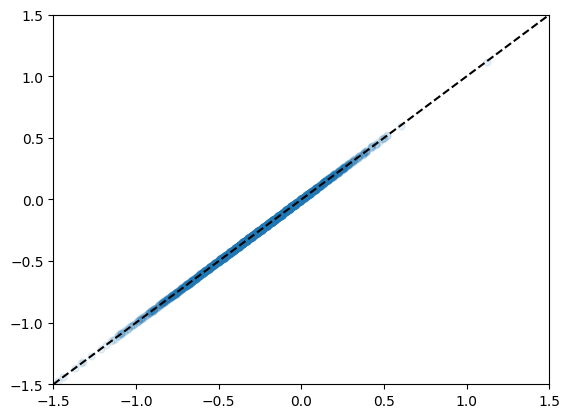

In [85]:
plt.plot(combined['logSFR_FUV'], combined['sfr_fuv'], 'o', alpha=0.1, markersize=5)
plt.plot([-1.5, 1.5], [-1.5, 1.5], 'k--')
plt.axis((-1.5, 1.5, -1.5, 1.5))

Similarly, for the MIR, we get similar good agreement, except for a small offset since Ross has actually applied a correction of $\log_{10}(1.06)$, which is only approximately $0.03\,\textrm{dex}$.

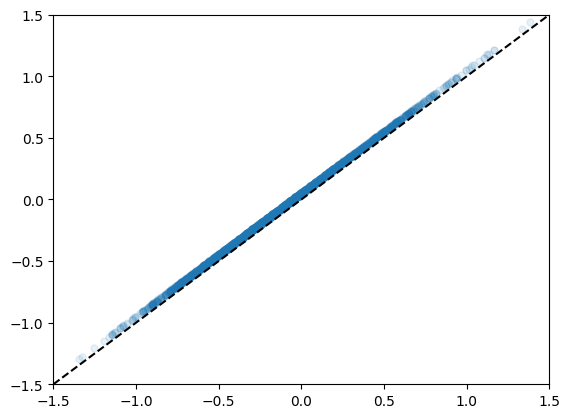

In [86]:
plt.plot(combined['logSFR_22'], combined['sfr_22'], 'o', alpha=0.1, markersize=5)
plt.plot([-1.5, 1.5], [-1.5, 1.5], 'k--')
plt.axis((-1.5, 1.5, -1.5, 1.5));

An example analysis using the data is in a separate notebook.